### Цель проекта: 
отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

### Задача проекта:
провести разведывательный анализ данных и составить отчёт по его результатам. 

Для начала загружаем все необходимые библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv('stud_math.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

В данных много пропусков, их нужно обработать, либо удалить либо заполнить. Я решила заполнить пропуски при помощи interpolation, на мой взгляд так сохраняется пропорция значений

Создаем формулу для заполнения пропусков в столбцах методом interpolation, method='pad'

In [4]:
def fill_by_interpolate (col):
    df[col].interpolate(method='pad',inplace=True)

Заполняем пропуски

In [5]:
for col in df.columns:
    fill_by_interpolate(col)

Создаем формулу для заполнения оставшихся пропусков модой

In [6]:
def fill_by_mode(col):
    df[col].fillna(df[col].mode()[0], inplace=True)

Заполняем ячейки модой

In [7]:
for col in df.columns:
    fill_by_mode(col)

Проверяем датафрейм на пропуски

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              395 non-null    object 
 4   famsize              395 non-null    object 
 5   Pstatus              395 non-null    object 
 6   Medu                 395 non-null    float64
 7   Fedu                 395 non-null    float64
 8   Mjob                 395 non-null    object 
 9   Fjob                 395 non-null    object 
 10  reason               395 non-null    object 
 11  guardian             395 non-null    object 
 12  traveltime           395 non-null    float64
 13  studytime            395 non-null    float64
 14  failures             395 non-null    float64
 15  schoolsup            395 non-null    obj

Все пропуски заполнены, можно приступать к более конкретному анализу по столбцам

Создаем и применяем формулу для просмотра всех не числовых столбцов

In [9]:
def info_obj_columns(obj_col):
    obj_info = df[obj_col].value_counts()
    print(obj_info )

In [10]:
obj_cols = df.select_dtypes(include = [np.object]).columns
for obj_col in obj_cols:
    info_obj_columns(obj_col)

GP    349
MS     46
Name: school, dtype: int64
F    208
M    187
Name: sex, dtype: int64
U    304
R     91
Name: address, dtype: int64
GT3    280
LE3    115
Name: famsize, dtype: int64
T    353
A     42
Name: Pstatus, dtype: int64
other       138
services    105
at_home      63
teacher      57
health       32
Name: Mjob, dtype: int64
other       215
services    115
teacher      30
at_home      19
health       16
Name: Fjob, dtype: int64
course        146
reputation    108
home          105
other          36
Name: reason, dtype: int64
mother    273
father     93
other      29
Name: guardian, dtype: int64
no     343
yes     52
Name: schoolsup, dtype: int64
yes    243
no     152
Name: famsup, dtype: int64
no     224
yes    171
Name: paid, dtype: int64
yes    203
no     192
Name: activities, dtype: int64
yes    312
no      83
Name: nursery, dtype: int64
yes    374
no      21
Name: higher, dtype: int64
yes    330
no      65
Name: internet, dtype: int64
no     260
yes    135
Name: romantic, 

Не числовые столбцы на данный момент не нуждаются в дальнейшей обработке

Создаем фоормулу для определения границ выбросов 

In [11]:
def outliers (num_col):
    IQR = df[num_col].quantile(0.75) - df[num_col].quantile(0.25)
    perc25 = df[num_col].quantile(0.25)
    perc75 = df[num_col].quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{},{}]".format(f, l))

Создаем фоормулу для замены выбросов на моду

In [12]:
def fill_outliers(num_col):
    IQR = df[num_col].quantile(0.75) - df[num_col].quantile(0.25)
    perc25 = df[num_col].quantile(0.25)
    perc75 = df[num_col].quantile(0.75)
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    mode_col = df[num_col].mode()[0]
    df[num_col] = df[num_col].apply(
        lambda x: mode_col if x > l or x < f else x)

## Приступаем к анализу и преобразованию числовых столбцов

In [13]:
num_cols = df.select_dtypes(exclude = [np.object]).columns
num_cols 

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'studytime, granular', 'famrel', 'freetime', 'goout', 'health',
       'absences', 'score'],
      dtype='object')

### Column 'age'

Начинаем анализ цифровых столбцов, со столбца 'age'

Строим гистограмму распределения значений

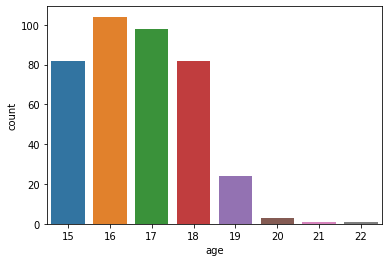

In [14]:
sns.countplot(x = df['age'], data = df)

In [15]:
df.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

### Column 'Medu'

В этом столбце содержиться информация об образовании матери 

(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

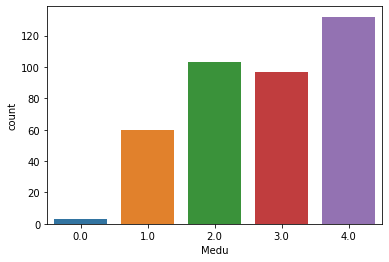

In [16]:
sns.countplot(x = df['Medu'], data = df)

In [17]:
df.Medu.value_counts()

4.0    132
2.0    103
3.0     97
1.0     60
0.0      3
Name: Medu, dtype: int64

Выбросов в этом столбце нет, все данные понадобятся позже

### Column 'Fedu'

В этом столбце содержиться информация об образовании отца 

(0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

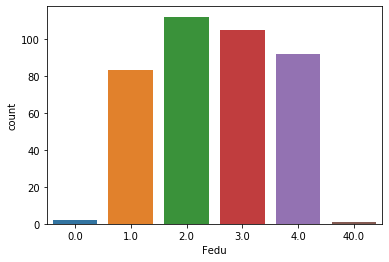

In [18]:
sns.countplot(x = df['Fedu'], data = df)

In [19]:
df.Fedu.value_counts()

2.0     112
3.0     105
4.0      92
1.0      83
0.0       2
40.0      1
Name: Fedu, dtype: int64

Значение 40 является выбросом и есть смысл заменить его на 4, возможно произошла ошибка и вместо 4 внесли в фаил 40.


In [20]:
df.loc[df['Fedu'] == 40,'Fedu'] = 4

In [21]:
df.Fedu.value_counts()

2.0    112
3.0    105
4.0     93
1.0     83
0.0      2
Name: Fedu, dtype: int64

### Column 'traveltime'

 В этом столбце содержиться информация о времени, которое тратиться на дорогу до школы
 
 (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

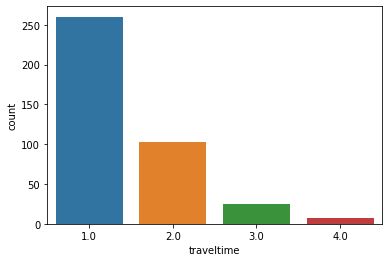

In [22]:
sns.countplot(x = df['traveltime'], data = df)

In [23]:
df.traveltime.value_counts()

1.0    260
2.0    103
3.0     25
4.0      7
Name: traveltime, dtype: int64

Выбросов нет

### Column 'studytime'

В данном столбце содержиться информация о времени, которое тратиться на учёбу помимо школы в неделю 

(1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

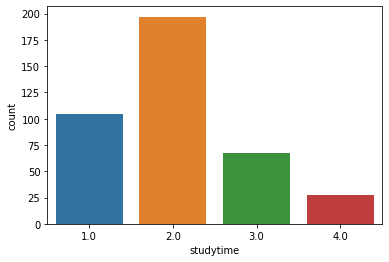

In [24]:
sns.countplot(x = df['studytime'], data = df)

In [25]:
df.studytime.value_counts()

2.0    197
1.0    104
3.0     67
4.0     27
Name: studytime, dtype: int64

Выбросов нет

### Column 'failures'

Данный столбец показвает количество внеучебных неудач

(n, если 1<=n<=3, иначе 0)

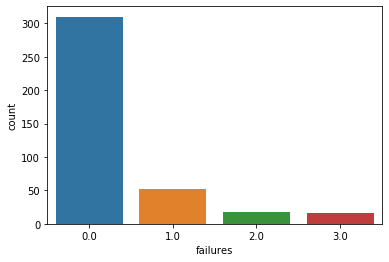

In [26]:
sns.countplot(x = df['failures'], data = df)

In [27]:
df.failures.value_counts()

0.0    310
1.0     52
2.0     17
3.0     16
Name: failures, dtype: int64

Выбросов нет

### Column 'studytime, granular'

На данный момент не понятно, что за информация храниться в этом столбце.

Во время дальнейшего анализа будет понятно, оставлять его или это не важная информация.

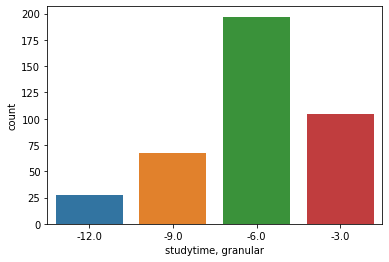

In [28]:
sns.countplot(x = df['studytime, granular'], data = df)

### Column 'famrel'

В этом столбце содержится информация о семейных отношенияй 

(от 1 - очень плохо до 5 - очень хорошо)

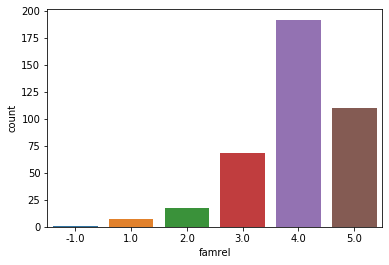

In [29]:
sns.countplot(x = df['famrel'], data = df)

In [30]:
df.famrel.value_counts()

 4.0    192
 5.0    110
 3.0     68
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

В данном столбце есть один явный выброс, это -1, следуя логике заполнения предыдущих столбцов, можем поменять это значение на 1.

In [31]:
df.loc[df['famrel'] == -1,'famrel'] = 1

In [32]:
df.famrel.unique()

array([4., 5., 3., 1., 2.])

### Column 'freetime'

Данная колонка отражает свободное время после школы 

от 1 - очень мало до 5 - очень мого

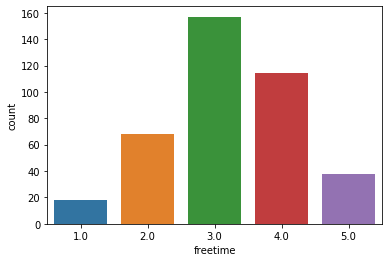

In [33]:
sns.countplot(x = df.freetime, data = df)

В данном столбце выбросов нет

### Column 'goout'

Данная коллонка показывает время проведенное с друзьями 

от 1 - очень мало до 5 - очень много

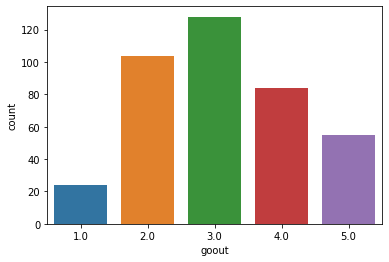

In [34]:
sns.countplot(x = df.goout, data = df)

В данном столбце выбросов нет

### Column 'health'

в данном столбце описано текущее состояние здоровья 

от 1 - очень плохо до 5 - очень хорошо

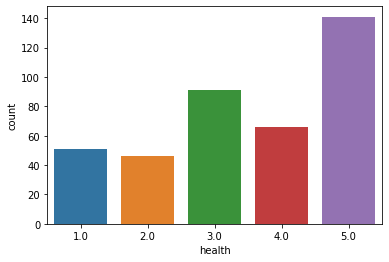

In [35]:
sns.countplot(x = df.health, data = df)

В данном столбце выбросов нет

### Column 'absences'

В данном столбце содержиться информация о количестве пропущенных занятий

In [36]:
df.absences.value_counts()

0.0      117
2.0       62
4.0       53
6.0       32
8.0       21
10.0      18
12.0      13
14.0      13
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

Определяем границы выбросов

In [37]:
outliers ('absences')

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0,20.0]


Применяем формулу, которая заменяет выбросы на моду

In [38]:
fill_outliers('absences')

Просматриваем значения

In [39]:
df.absences.value_counts()

0.0     134
2.0      62
4.0      53
6.0      32
8.0      21
10.0     18
12.0     13
14.0     13
3.0       8
16.0      7
7.0       6
18.0      5
5.0       5
20.0      4
1.0       3
9.0       3
11.0      2
13.0      2
15.0      2
19.0      1
17.0      1
Name: absences, dtype: int64

Строим гистограмму для просмотра получившихся данных и их распределения.

(array([134.,   3.,  62.,   8.,  53.,   5.,  32.,   6.,  21.,   3.,  18.,
          2.,  13.,   2.,  13.,   2.,   7.,   1.,   5.,   5.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20.]),
 <a list of 20 Patch objects>)

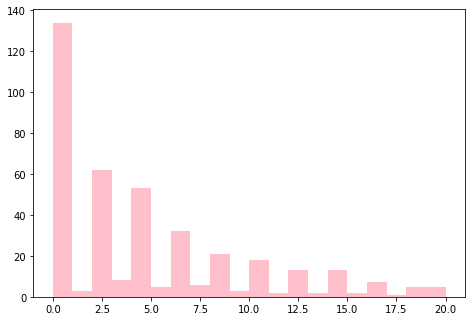

In [40]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['absences'], bins = 20, color = 'pink')

### Column 'score'

В данном столбце содержиться информация о баллах по госэкзамену по математике

In [41]:
df.score.value_counts()

50.0     54
55.0     46
0.0      38
75.0     33
65.0     33
60.0     33
40.0     31
70.0     27
45.0     27
80.0     17
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

Строим гистограмму распределения оценок

(array([38.,  0.,  0.,  0.,  1.,  7., 15.,  9., 31., 27., 54., 46., 33.,
        33., 27., 33., 17.,  6., 12.,  6.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <a list of 20 Patch objects>)

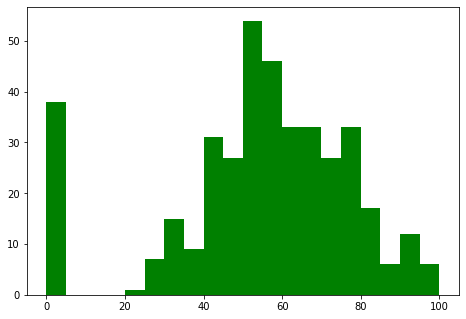

In [42]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['score'], bins = 20, color = 'green')

Выбросов в данном столбце нет, все данные находятся в диапозоне от 0 до 100

## Смотрим корреляцию признаков датасета

In [43]:
df_corr = df.corr()

Строим матрицу корреляций

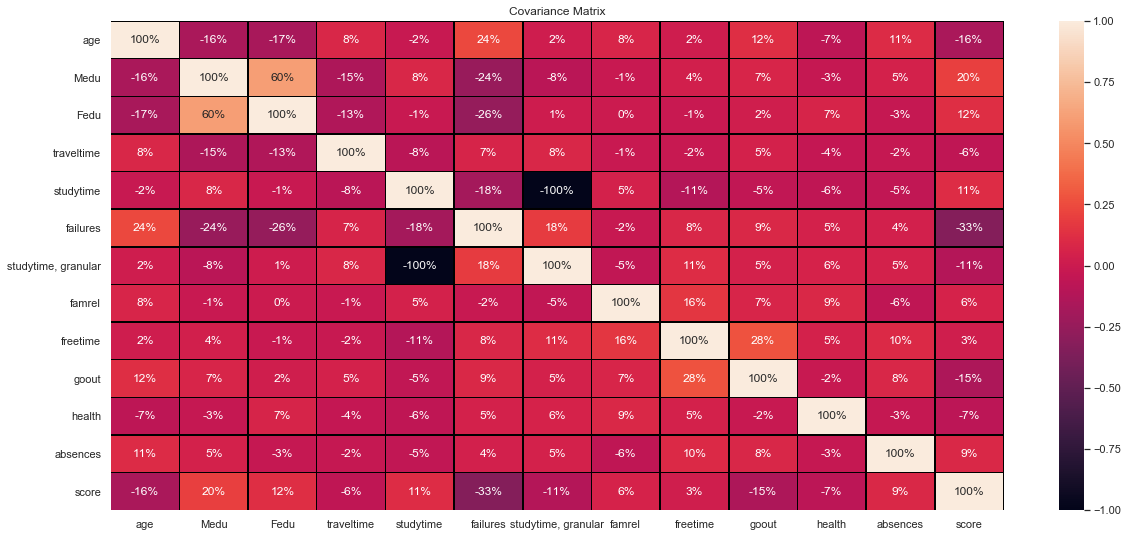

In [44]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Covariance Matrix')
sns.heatmap(df_corr, mask=df_corr.isnull(), annot=True,
            fmt='.0%', linewidths=0.5, linecolor='black')

Столбец 'studytime, granular' имеет полную обратную корреляцию со столбцом 'studytime', поэтому его можно исключить из дальнейшего анализа

In [45]:
df_corr = df.loc[:, [x for x in df_corr.columns if x != 'studytime, granular' ]].corr()

Строим новую матрицу корреляций

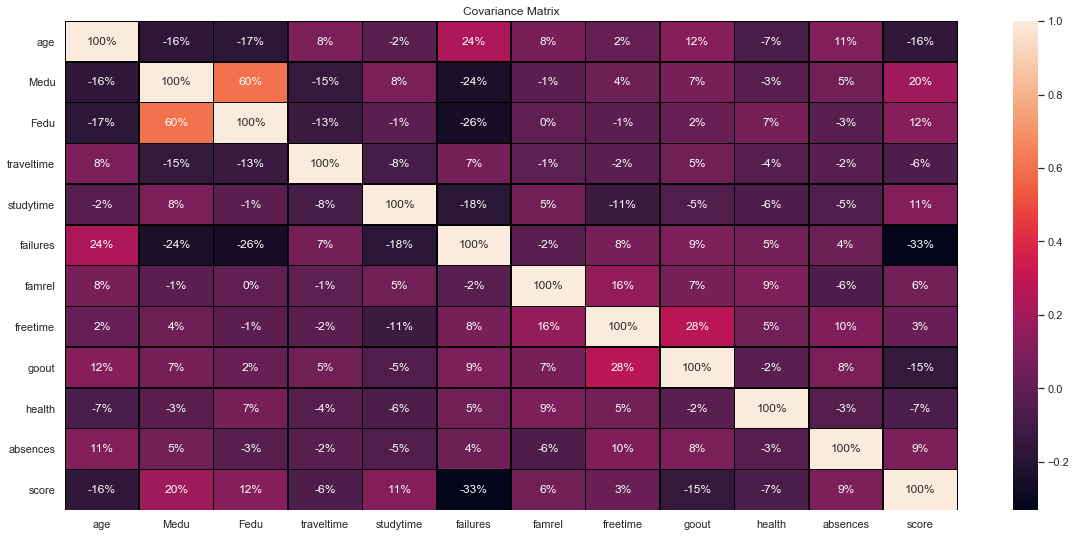

In [46]:
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Covariance Matrix')
sns.heatmap(df_corr, mask=df_corr.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black');

Из этой матрицы корреляций нельзя сделать вывод о сильном влиянии какого-то одного признака на значение score, но несколько переменных хоть и слабо но корелируют, это: age, Medu, Fedu, studytime, failures и goout. Для дальнешего анализа оставим только эти числовые столбцы.

Пишем функцию для создания боксплотов

In [47]:
def get_boxplot(obj_col):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x = obj_col , y='score', 
                data = df,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + obj_col)
    plt.show()

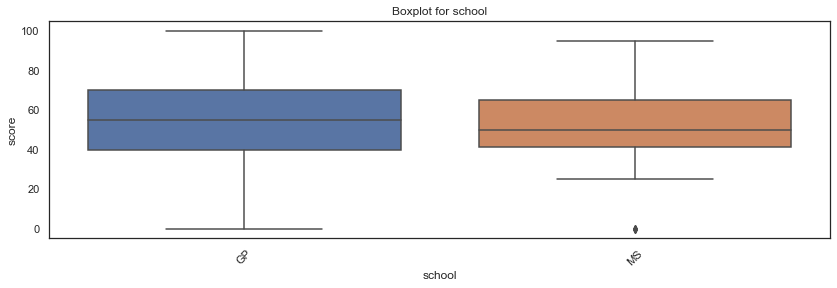

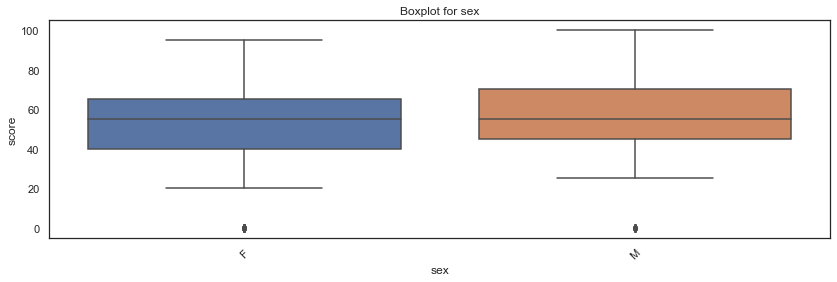

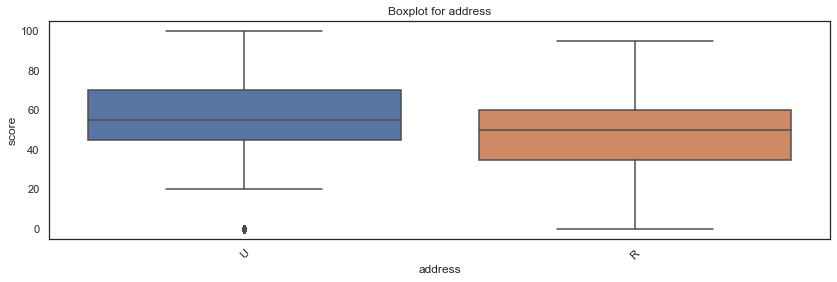

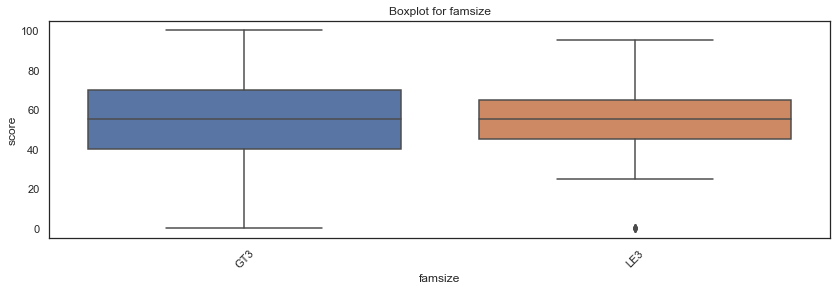

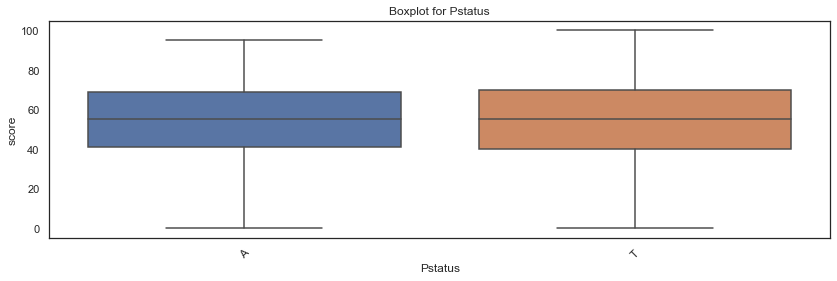

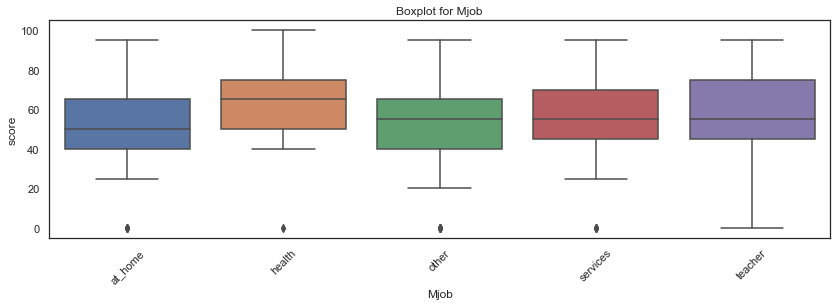

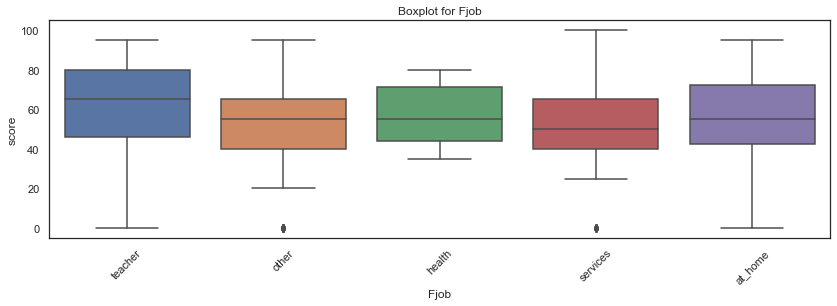

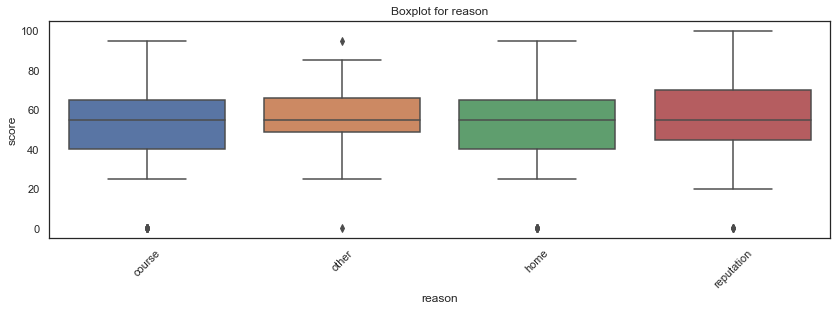

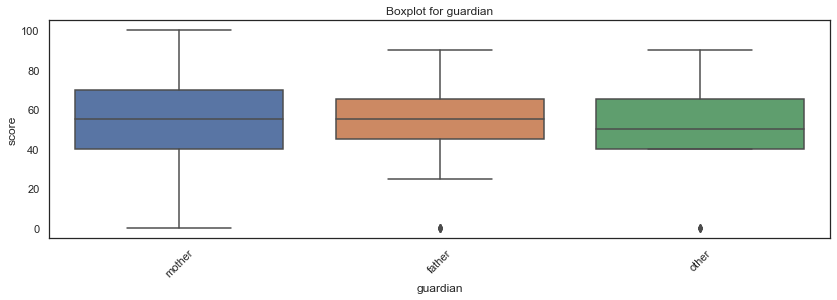

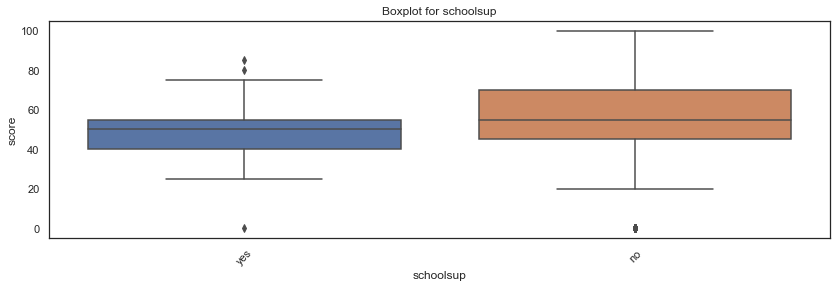

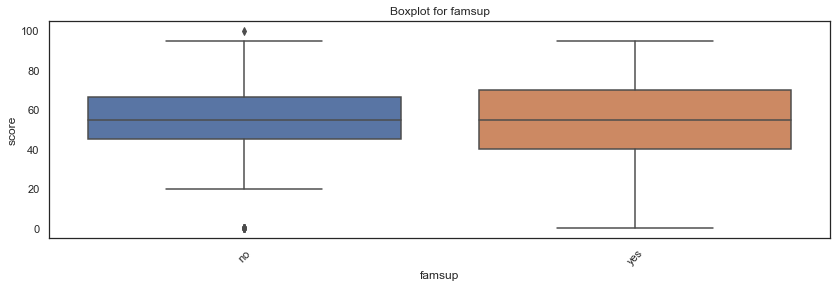

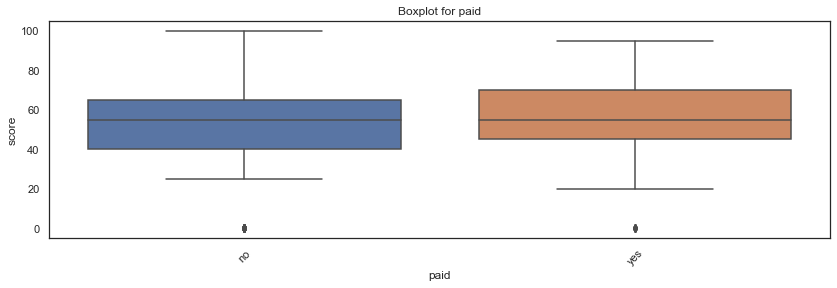

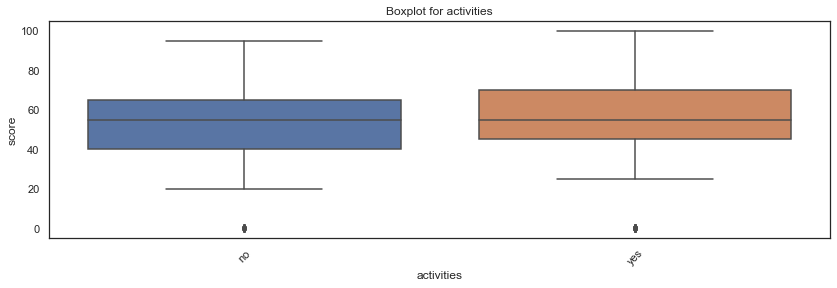

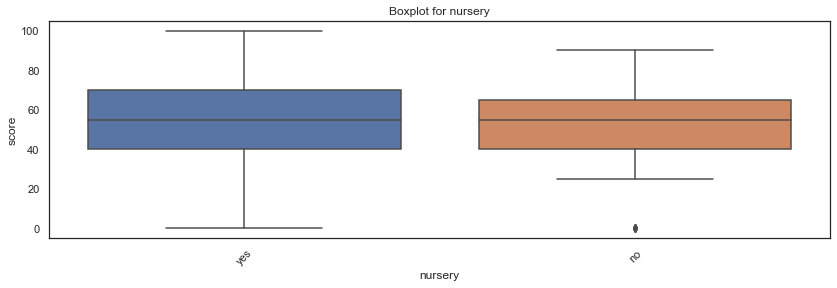

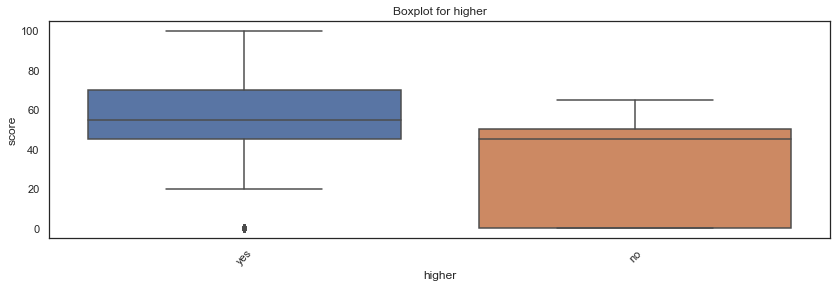

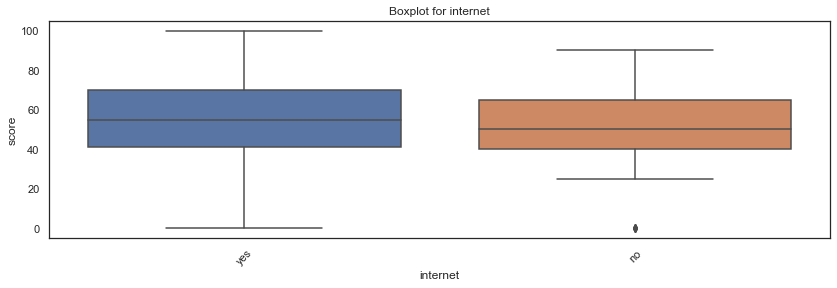

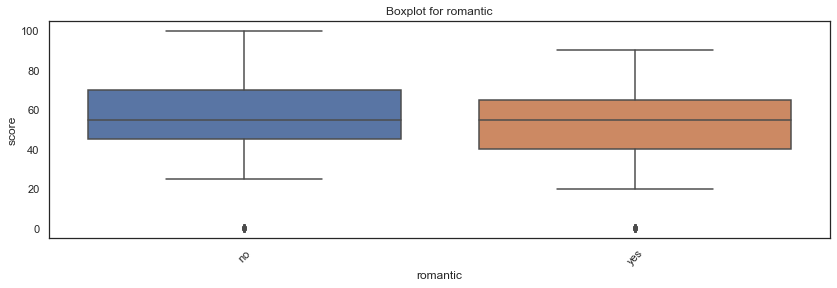

In [48]:
for obj_col in obj_cols:
    get_boxplot(obj_col)

По боксплотам видны различия столбцах adress, Mjob, Fjob, higher и scoolsup, но следует проверить значимы ли статистически эти различия при помощи ttest

In [49]:
def get_stat_dif(obj_col):
    cols = df.loc[:, obj_col].value_counts().index[:2]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, obj_col] == comb[0], 'score'], 
                        df.loc[df.loc[:, obj_col] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', obj_col)
            break

In [50]:
for obj_col in obj_cols:
    get_stat_dif(obj_col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки reason
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Составляем итоговый датафрейм из числовых столбцов показавших корреляцию выше 10% и не числовых столбцов у которых найдены статистически значимые различия.

In [51]:
col_list = ['sex','address','reason', 'higher', 'romantic','age',
                         'Medu', 'Fedu','studytime', 'failures',
                         'goout','score']

In [52]:
df = df[col_list]

In [53]:
df

,sex,address,reason,higher,romantic,age,Medu,Fedu,studytime,failures,goout,score
0,F,U,course,yes,no,18,4.0,4.0,2.0,0.0,4.0,30.0
1,F,U,course,yes,no,17,1.0,1.0,2.0,0.0,3.0,30.0
2,F,U,other,yes,no,15,1.0,1.0,2.0,3.0,2.0,50.0
3,F,U,home,yes,yes,15,4.0,2.0,3.0,0.0,2.0,75.0
4,F,U,home,yes,no,16,3.0,3.0,2.0,0.0,2.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
390,M,U,course,yes,no,20,2.0,2.0,2.0,2.0,4.0,45.0
391,M,U,course,yes,no,17,3.0,1.0,1.0,0.0,5.0,80.0
392,M,R,course,yes,no,21,1.0,1.0,1.0,3.0,3.0,35.0
393,M,R,course,yes,no,18,3.0,2.0,1.0,0.0,1.0,50.0


### Выводы:
из 30 столбцов в исходном датасете, а финальный вошли только 12, то есть только 11 признаков оказывают существенное влияние на переменную score.